# Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import re
import numpy as np
from numpy import array
import time
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from wordcloud import WordCloud 
import pickle

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
#importing dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Embedding


# Read the COCO dataset

In [3]:
BASE_PATH = 'F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset'

# Read training dataset 

In [4]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

train_data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
train_data['image'] = train_data['image'].apply(
    lambda x: f'{x}'
)
train_data = train_data.reset_index(drop=True)
train_data.head()

,image,caption
0,000000203564.jpg,A bicycle replica with a clock as the front wh...
1,000000322141.jpg,A room with blue walls and a white sink and door.
2,000000016977.jpg,A car that seems to be parked illegally behind...
3,000000106140.jpg,A large passenger airplane flying through the ...
4,000000106140.jpg,There is a GOL plane taking off in a partly cl...


In [5]:
#converting the text files to pandas dataframe   
image_tokens=train_data.copy()

train_image_names=pd.read_csv("F:\\Ml files\\COCO dataset Image captioning\\data\\train.csv")
val_image_names=pd.read_csv("F:\\Ml files\\COCO dataset Image captioning\\data\\validation.csv")
test_image_names=pd.read_csv("F:\\Ml files\\COCO dataset Image captioning\\data\\test.csv")

# Text (caption) preprocessing 

In [11]:
def preprocess(text):
    text = text.lower()
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [12]:
train_image_names['caption'] = train_image_names['caption'].apply(preprocess)
train_image_names.head()

,image,caption
0,000000203564.jpg,[start] a bicycle replica with a clock as the ...
1,000000322141.jpg,[start] a room with blue walls and a white sin...
2,000000016977.jpg,[start] a car that seems to be parked illegall...
3,000000106140.jpg,[start] a large passenger airplane flying thro...
4,000000106140.jpg,[start] there is a gol plane taking off in a p...


In [12]:
image_tokens = train_image_names.copy()
valid_image_tokens = val_image_names.copy()
test_image_tokens = test_image_names.copy()

In [13]:
train_image_names = train_image_names.drop(['caption'], axis=1)
train_image_names.head()

,image
0,000000203564.jpg
1,000000322141.jpg
2,000000016977.jpg
3,000000106140.jpg
4,000000106140.jpg


# Taking sample of the data

In [14]:
train_image_names = train_image_names.sample(n = 7000)
test_image_names = test_image_names.sample(n = 1500)
val_image_names = val_image_names.sample(n = 500)

# Creating train dictionary having key as the image id and value as a list of its captions

In [15]:
train_captions={}

for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["image"]==train_image_names["image"].iloc[i]].caption)]
  train_captions[train_image_names["image"].iloc[i]]=l

  0%|          | 0/7000 [00:00<?, ?it/s]

In [70]:
train_captions

{'000000445887.jpg': ['[start] a pizza sitting on top of a bbq grill next to a tree [end]',
  '[start] a pizza is cooking on a grill outside [end]',
  '[start] a large cooked pizza on a grill outside [end]',
  '[start] pizza on the grill keeps the kitchen cool on a hot day [end]',
  '[start] a silver bbq with a square pizza and grass and bushes [end]'],
 '000000545111.jpg': ['[start] a see through container with a lemon and apple dropped in it [end]',
  '[start] couple of balloons being tossed in a clear bucket of water [end]',
  '[start] a lemon and an apple in a bucket of water [end]',
  '[start] a tub of water with two pieces of fruit floating in it [end]',
  '[start] the fruit is floating along in the water [end]'],
 '000000383039.jpg': ['[start] a horned ram and a sheep grazing in a fenced field [end]',
  '[start] some sheep chillin a pasture eattin some blades of grass [end]',
  '[start] two sheep grazing next to a white fence [end]',
  '[start] sheep one in mixed brown and white

# Creating test dictionary having key as the image id and value as a list of its captions

In [16]:
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(test_image_tokens[test_image_tokens["image"]==test_image_names["image"].iloc[i]].caption)]
  test_captions[test_image_names["image"].iloc[i]]=l

  0%|          | 0/1500 [00:00<?, ?it/s]

In [69]:
test_captions

{'000000410456.jpg': ['a surfing instructor teaches students with surfboards on a beach in front of large hotel buildings.',
  'Four people learning how to surf on the beach. ',
  'The people are practicing riding their surfboards on the beach.',
  'Several people on the beach and some have surf boards. ',
  'A group of people standing on a  beach riding surfboards.'],
 '000000425906.jpg': ['A man flying through the air while riding a snowboard.',
  'a person jumping a snow board in the air ',
  'People look on as an airborne snowboarder competes.',
  'a snow boarder doing a flip for the audience ',
  'A person is taken in this very picture.\n'],
 '000000073153.jpg': ['A person talking on a phone with a tree in the foreground.',
  'A close up of bark on a tree with a young man on a cell phone in the background',
  'A man standing with a cell phone by a tree.',
  'a person standing in a forest using a cell phone.',
  'The tree bark in the foreground is clear while the person in the back

# Creating validation dictionary having key as the image id and value as a list of its captions

In [17]:
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(valid_image_tokens[valid_image_tokens["image"]==val_image_names["image"].iloc[i]].caption)]
  validation_captions[val_image_names["image"].iloc[i]]=l

  0%|          | 0/500 [00:00<?, ?it/s]

In [71]:
validation_captions

{'000000045359.jpg': ['two large vases in a structure behind a fence ',
  'Two large urns in a stone shed behind a gate.',
  'Two large vases next to each other behind a fence.  ',
  'Two very large vases that are behind a fence.',
  'a couple of large jars behind a fence'],
 '000000114229.jpg': ['Two women sitting in seats that are holding cellphones.',
  'A couple of girls wearing "Astros" baseball uniforms talking on their cell phones.',
  'some women with wigs and baseball uniforms and cellphones',
  'Houston Astros fans with big hair talk on their cell phones.',
  'Two Astros fans use their cell phones in the stands'],
 '000000392627.jpg': ['A microwave oven sitting next to a refrigerator freezer.',
  'A stainless steel refrigerator in a kitchen with wooden cabinets.',
  'A microwave sits on a counter next to a stainless steel refrigerator.',
  'A kitchen has stainless steel appliances and wood cabinetry.',
  'A kitchen with a counter, refrigerator, cabinets, drawers and a microwa

# ResNet Model to extract image features

In [18]:
model= ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

In [19]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Predicting training features

In [21]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset/train2017/"
train_features={}
c=0
for image_name in tqdm(train_captions):
    img_path = path+image_name
    img = image.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    train_features[image_name]=features.squeeze()

  0%|          | 0/6826 [00:00<?, ?it/s]

In [22]:
with open( "F:\\Ml files\\COCO dataset Image captioning\\model\\train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

# Predicting test features

In [23]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset/val2017/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path = path+image_name
  img = image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|          | 0/1335 [00:00<?, ?it/s]

In [24]:
with open( "F:\\Ml files\\COCO dataset Image captioning\\model\\test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

# Predicting validation features

In [25]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset/train2017/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|          | 0/492 [00:00<?, ?it/s]

In [26]:
with open( "F:\\Ml files\\COCO dataset Image captioning\\model\\validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

# Building vocabulary size with all captions 

In [27]:
def update_without_overwriting(d, x):
    d.update({k: v for k, v in x.items() if k not in d})

In [28]:
all_captions_dict = {}
update_without_overwriting(all_captions_dict, train_captions)
update_without_overwriting(all_captions_dict, test_captions)
update_without_overwriting(all_captions_dict, validation_captions)

In [29]:
len(all_captions_dict)

8653

In [30]:
all_captions=[]

for image in tqdm(all_captions_dict):
  for captions in all_captions_dict[image]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

  0%|          | 0/8653 [00:00<?, ?it/s]


2754990
11688


In [31]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

# Forming dictionaries containg mapping of words to indices and indices to words

In [32]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [33]:
#forming dictionary having encoded captions
train_encoded_captions={}
for image in tqdm(train_captions):
    train_encoded_captions[image] = []
    for i in range(2):
        train_encoded_captions[image].append([words_to_indices[s] for s in train_captions[image][i].split(" ")])


  0%|          | 0/6826 [00:00<?, ?it/s]

In [34]:
validation_encoded_captions={}
for image in tqdm(validation_captions):
    validation_encoded_captions[image] = []
    for i in range(1):
        validation_encoded_captions[image].append([words_to_indices[s] for s in validation_captions[image][i].split(" ")])


  0%|          | 0/492 [00:00<?, ?it/s]

In [36]:
for image in tqdm(validation_encoded_captions):
    validation_encoded_captions[image]=pad_sequences(validation_encoded_captions[image], maxlen=max_length, padding='post')

  0%|          | 0/492 [00:00<?, ?it/s]

In [37]:
for image in tqdm(train_encoded_captions):
    train_encoded_captions[image]=pad_sequences(train_encoded_captions[image], maxlen=max_length, padding='post')

  0%|          | 0/6826 [00:00<?, ?it/s]

In [38]:
for image in tqdm(train_encoded_captions):
  print(train_encoded_captions[image])
  break

  0%|          | 0/6826 [00:00<?, ?it/s]

[[ 1712  2702  6152  6683  5923 10430  9700  2702 10496  4354  4086  8731
   2702 11046  4647     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1712  2702  6152 10377  1453  5923  2702  4354  5005  4647     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


In [41]:
for x in train_encoded_captions['000000445887.jpg'][0]:
  print(indices_to_words[x])

[start]
a
pizza
sitting
on
top
of
a
bbq
grill
next
to
a
tree
[end]
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [42]:
train_encoded_captions["000000445887.jpg"][0][0:1].tolist()

[1712]

# Data Generator

In [43]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
    X1, X2, Y = list(), list(), list()
    max_length=40
    n=0
    for image in tqdm(train_encoded_captions):
        n+=1
        for i in range(2):
            for j in range(1,40):
                curr_sequence=train_encoded_captions[image][i][0:j].tolist()
                next_word=train_encoded_captions[image][i][j]
                curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                one_hot_next_word=to_categorical([next_word],vocab_size)[0]
                X1.append(train_features[image])
                X2.append(curr_sequence)
                Y.append(one_hot_next_word)
        if(n==num_of_photos):
            yield [[array(X1), array(X2)], array(Y)]
            X1, X2, Y = list(), list(), list()
            n=0

In [48]:
for i in train_features:
  print(train_features[i].shape[0])
  break

2048


# Image captioning model

In [49]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      2992384     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

In [50]:
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.compile(optimizer='adam',  loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [55]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [56]:
len(train_encoded_captions)

6826

# Training the ResNet+LSTM model

In [57]:
epochs=20
no_of_photos=5
train_steps=len(train_encoded_captions)//no_of_photos
validation_steps = len(validation_encoded_captions)//no_of_photos
for i in range(epochs):
    train_generator = data_generator(train_encoded_captions,validation_features,no_of_photos)
    valid_generator = data_generator(validation_encoded_captions,train_features,no_of_photos)
    model.fit_generator(train_generator,epochs=1, steps_per_epoch=train_steps,
                        validation_data=valid_generator, validation_steps = validation_steps,verbose=1)

Epoch 1/20
875/875 [==============================] - 869s 970ms/step - loss: 4.0858 - acc: 0.2659 - val_loss: 3.4006 - val_acc: 0.3909
Epoch 2/20
875/875 [==============================] - 691s 784ms/step - loss: 3.2480 - acc: 0.3950 - val_loss: 3.1832 - val_acc: 0.4136
Epoch 3/20
875/875 [==============================] - 708s 802ms/step - loss: 3.0159 - acc: 0.4192 - val_loss: 3.0933 - val_acc: 0.4247
Epoch 4/20
875/875 [==============================] - 704s 798ms/step - loss: 2.8772 - acc: 0.4318 - val_loss: 3.0632 - val_acc: 0.4269
Epoch 5/20
875/875 [==============================] - 704s 799ms/step - loss: 2.7743 - acc: 0.4422 - val_loss: 3.0336 - val_acc: 0.4311
Epoch 6/20
875/875 [==============================] - 907s 970ms/step - loss: 2.5888 - acc: 0.4859 - val_loss: 2.9506 - val_acc: 0.4909
Epoch 7/20
875/875 [==============================] - 876s 784ms/step - loss: 2.2480 - acc: 0.5150 - val_loss: 2.8832 - val_acc: 0.5436
Epoch 8/20
875/875 [============================

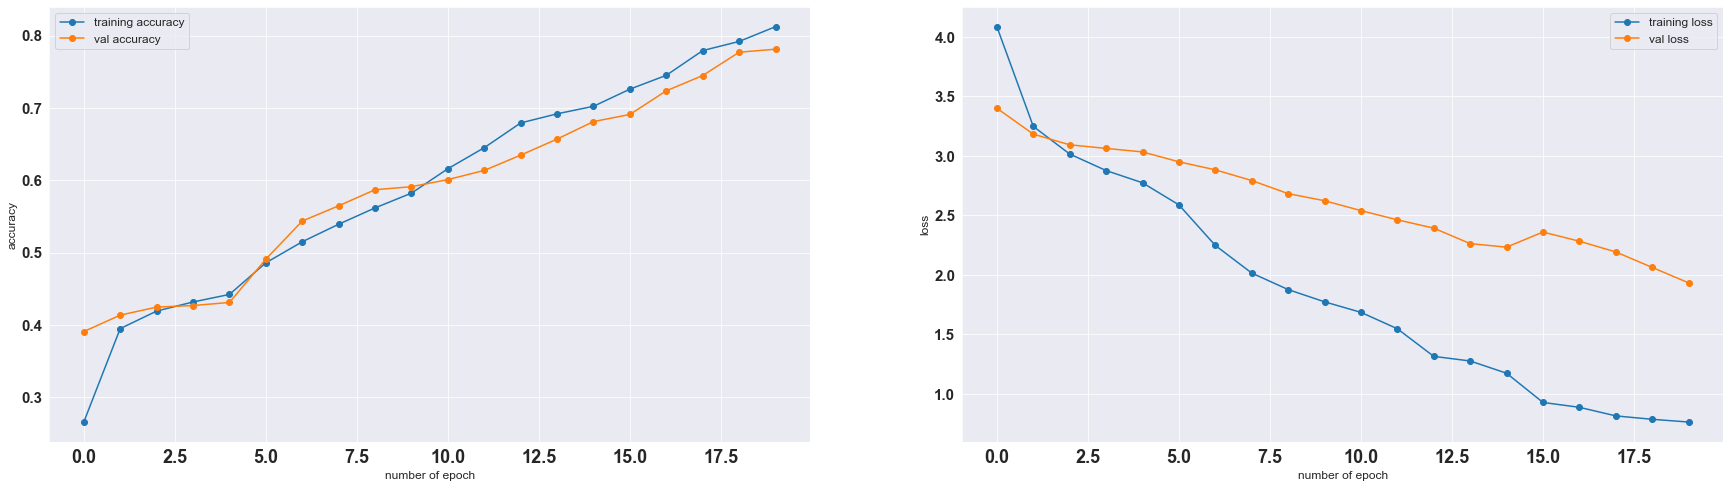

In [59]:
fig = plt.figure(figsize = (30, 8))
plt.subplot(121)
plt.xlabel("number of epoch")
plt.ylabel("accuracy")
plt.plot(model.history["acc"], label = 'training accuracy', marker='o')
plt.plot(model.history["val_acc"], label = 'val accuracy',marker='o')
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=0,axis='x', labelsize=18)
plt.grid('white')
plt.legend()
plt.subplot(122)
plt.xlabel("number of epoch")
plt.ylabel("loss")
plt.plot(model.history["loss"], label = 'training loss',marker='o')
plt.plot(model.history["val_loss"], label = 'val loss',marker='o')
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=0,axis='x', labelsize=18)
plt.grid('white')
plt.legend()

# Greedy Search function

In [60]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

# Predicting Captions on Test Set using Greedy Search

# Calculating Average Bleu Score on Test Set using Greedy Search

In [65]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|█████████████████████████████████████████████████████████████████████████| 1335/1335 [00:00<00:00, 1339247.99it/s]


Bleu score on Greedy search
Score:  0.4776410409015063


# Beam Search Function

In [66]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

# Predicting Captions on Test Set using Beam Search with k=3

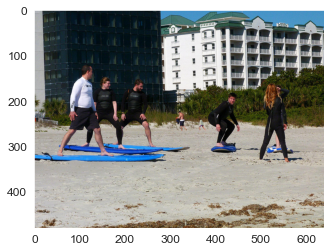

Referance Captions: 
surfing instructor teaches students with surfboards on a beach in front of large hotel
people learning how to surf on the beach.
people are practicing riding their surfboards on the
people on the beach and some have surf boards.
group of people standing on a  beach riding
Predicted Caption: 
surfing instructor teaches students with surfboards  on the beach 
bleu score:  0.62695170360364


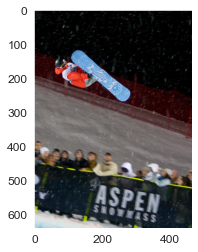

Referance Captions: 
man flying through the air while riding a
person jumping a snow board in the air
look on as an airborne snowboarder
snow boarder doing a flip for the audience
person is taken in this very
Predicted Caption: 
snow boarder doing a flip for the audience
bleu score:  0.7225489456366117


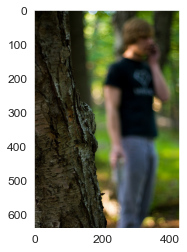

Referance Captions: 
person talking on a phone with a tree in the
close up of bark on a tree with a young man on a cell phone in the
man standing with a cell phone by a
person standing in a forest using a cell
tree bark in the foreground is clear while the person in the background is
Predicted Caption: 
person standing in a forest using a cell phone
bleu score:  0.6412369878966458


In [72]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset/val2017/"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

# Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [68]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

100%|█████████████████████████████████████████████████████████████████████████| 1335/1335 [00:00<00:00, 1339247.99it/s]


Bleu score on Beam search with k=3
Score:  0.4986302654789412
